# Desarrollo de modelos predictivos
En este python book se tratará el desarrollo de modelos predictivos para la predicción del precio de una acción al año siguiente, empleando los datos obtenidos de FinnHub y AlphaVantage.

## Librerías y paquetes
Comenzaremos importando las librerias necesarias para la construcción de los modelos

In [2]:
# Importar las bibliotecas necesarias
import pandas                as pd
import numpy                 as np

# Medicion y benchmark
import time
from sklearn                 import metrics
from sklearn.dummy           import DummyRegressor

# Creacion de train/test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Preparacion del pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, MaxAbsScaler, OneHotEncoder

# Creacion Modelos básicos
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.linear_model    import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm             import SVR
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Creación de Redes de Neuronas
import tensorflow            as tf
from itertools               import product
from scipy.sparse            import csr_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, GRU, Flatten, Dense, Dropout
!pip install scikeras
from scikeras.wrappers       import KerasRegressor
from tensorflow.keras.callbacks    import EarlyStopping
from tensorflow.keras.regularizers import l2

# Exportacion del modelo
from sklearn.ensemble        import GradientBoostingRegressor
from joblib                  import dump, load

# Estudio y representación
import matplotlib.pyplot     as plt

## Preprocesado
A continuación, debemos obtener los datos y preprocesarlos, para poder llevar a cabo el entrenamiento con datos relevantes

In [3]:
# Cargar los datos
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fundamentals.csv', sep=',')
preprocessed_df = df.copy()

# 1. Eliminar outliers y valores infinitos
price_limit = preprocessed_df['sharePrice'].quantile(0.985)
preprocessed_df = preprocessed_df[(preprocessed_df['sharePrice']<=price_limit) & (preprocessed_df['1y_sharePrice']<=price_limit)]
preprocessed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Computar cashflows
preprocessed_df['cashflowFromFinancing'] = pd.to_numeric(preprocessed_df['cashflowFromFinancing'], errors='coerce')
preprocessed_df['cashflowFromInvestment'] = pd.to_numeric(preprocessed_df['cashflowFromInvestment'], errors='coerce')
preprocessed_df['operatingCashflow'] = pd.to_numeric(preprocessed_df['operatingCashflow'], errors='coerce')
preprocessed_df['changeInCashAndCashEquivalents'] = preprocessed_df['changeInCashAndCashEquivalents'].fillna(
    preprocessed_df['cashflowFromFinancing'] + preprocessed_df['cashflowFromInvestment'] + preprocessed_df['operatingCashflow']
)

# 3. Computar media del sector anual
preprocessed_df['fiscalDateEnding'] = pd.to_datetime(preprocessed_df['fiscalDateEnding'])
preprocessed_df['year'] = preprocessed_df['fiscalDateEnding'].dt.year
mean_price_by_sector_year = preprocessed_df.groupby(['sector', 'year'])['sharePrice'].mean().reset_index(name='meanSectorPrice')
preprocessed_df = preprocessed_df.merge(mean_price_by_sector_year, on=['sector', 'year'])

# 4. Eliminar columnas con +30% de valores faltantes
missing_percentage = preprocessed_df.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 30]
columns_to_drop.drop(labels=['changeInCashAndCashEquivalents'], inplace=True)
preprocessed_df.drop(columns=columns_to_drop.index, inplace=True)
# extra: Eliminar las filas donde '1y_sharePrice' es NaN, ya que no tendrán un valor objetivo
preprocessed_df = preprocessed_df.dropna(subset=['1y_sharePrice'])

# 5. Eliminar los años del COVID
preprocessed_df = preprocessed_df.loc[~(preprocessed_df['year'].isin([2020, 2021]))]

# 6. Eliminar columnas irrelevantes
columns_to_drop = ['Unnamed: 0', 'reportedCurrency', 'industria', 'year']
preprocessed_df.drop(columns=columns_to_drop, inplace=True)

## Creación de modelos básicos sin ajuste de hiperparámetros
Una vez se han preprocesado los datos, ya podemos emplearlos para la creación de los modelos. El siguiente paso será definir los datos de entrenamiento y test, así como la creación de un modelo dummy que funcione como benchmark. Además comenzamos a preparar el pipeline y a definir los modelos que emplearemos para la predicción

In [ ]:
# Separar la variable objetivo
y = preprocessed_df['1y_sharePrice']
X = preprocessed_df.drop('1y_sharePrice', axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba respetando la temporalidad
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Creamos un modelo dummy para usar como benchmark
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_dummy_pred = dummy_regr.predict(X_test)
dummy_MAE = metrics.mean_absolute_error(y_test, y_dummy_pred)
print(f"Dummy regressor MAE: {dummy_MAE}")

# Preparacion del pipeline -> creacion del transformador de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'string']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Diccionario de modelos a desarrollar
models = {
    "knn": KNeighborsRegressor(),
    "linear_regression": LinearRegression(),
    "ridge": Ridge(random_state=42),
    "lasso": Lasso(random_state=42),
    "decision_tree": DecisionTreeRegressor(random_state=42),
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "adaboost": AdaBoostRegressor(random_state=42),
    "svr": SVR(),
    "xgboost": XGBRegressor(random_state=42),
    "lightgbm": LGBMRegressor(random_state=42, verbose=-1),
}

Dummy regressor MAE: 34.17534043736865


A continuación emplearemos los modelos definidos para ver cuales se comportan mejor al no emplear ajuste de hiperparámetros

In [ ]:
print(f'Media de precios: {preprocessed_df["1y_sharePrice"].mean()}')

for model in models:
  start_t = time.time()
  # Crear una pipeline con el preprocesador y el clasificador
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
      ('regressor', models[model])
  ])

  # Entrenar el modelo y realizar predicciones
  pipeline.fit(X_train, y_train)
  y_predict = pipeline.predict(X_test)
  end_t = time.time()

  # Comprobamos el MAE respecto al dummy regressor
  MAE = metrics.mean_absolute_error(y_test, y_predict)
  diff_MAE = (dummy_MAE - MAE)*100 / dummy_MAE
  print(f"{model} MAE: {MAE}  --  mejora respecto a dummy: {diff_MAE}  --  Tiempo de ejecucion (s): {end_t - start_t}")


Media de precios: 38.954854550048125
knn MAE: 27.503675157377995  --  mejora respecto a dummy: 19.52186926189503  --  Tiempo de ejecucion (s): 91.32185411453247
linear_regression MAE: 27.243068665422474  --  mejora respecto a dummy: 20.28442638238113  --  Tiempo de ejecucion (s): 0.5679361820220947
ridge MAE: 23.029984476937376  --  mejora respecto a dummy: 32.61227486777134  --  Tiempo de ejecucion (s): 0.3105475902557373
lasso MAE: 20.177426985402  --  mejora respecto a dummy: 40.959104643360874  --  Tiempo de ejecucion (s): 0.5473577976226807
decision_tree MAE: 17.099543618250074  --  mejora respecto a dummy: 49.965257406616004  --  Tiempo de ejecucion (s): 19.413504123687744
random_forest MAE: 12.786338124554817  --  mejora respecto a dummy: 62.58606948484487  --  Tiempo de ejecucion (s): 1335.583333015442
gradient_boosting MAE: 12.854972987264299  --  mejora respecto a dummy: 62.3852379442337  --  Tiempo de ejecucion (s): 19.199392795562744
adaboost MAE: 19.94270503847901  --  mej

Como podemos comprobar, los modelos que tienen mayor precisión y se comportan mejor son los ensembles, en especial random forest, aunque este por contrapartida es el que más tiempo ha tardado en ser entrenado y evaluado. El segundo modelo con mejor precisión es Gradient Boosting, con un tiempo de ejecución aceptable. También, debemos destacar el lightgbm, un modelo con una precisión ligeramente inferior a los anteriormente mencionados, pero con un tiempo de entrenamiento muy reducido.

Por otro lado, los modelos más sencillos como los lineales, maquina de vector de soporte o KNN no consiguen ofrecer tan buenos resultados.

### Prueba de las predicciones
A continuación, vamos a preparar unos gráficos comparativos entre valores reales y predichos de algunas de empresas rivales en sus sectores y ampliamente conocidas, de manera que podamos ilustrar y entender mejor el funcionamiento de los modelos:

<ipython-input-6-0d124665726b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_symbol['fiscalDateEnding'] = pd.to_datetime(X_symbol['fiscalDateEnding'])


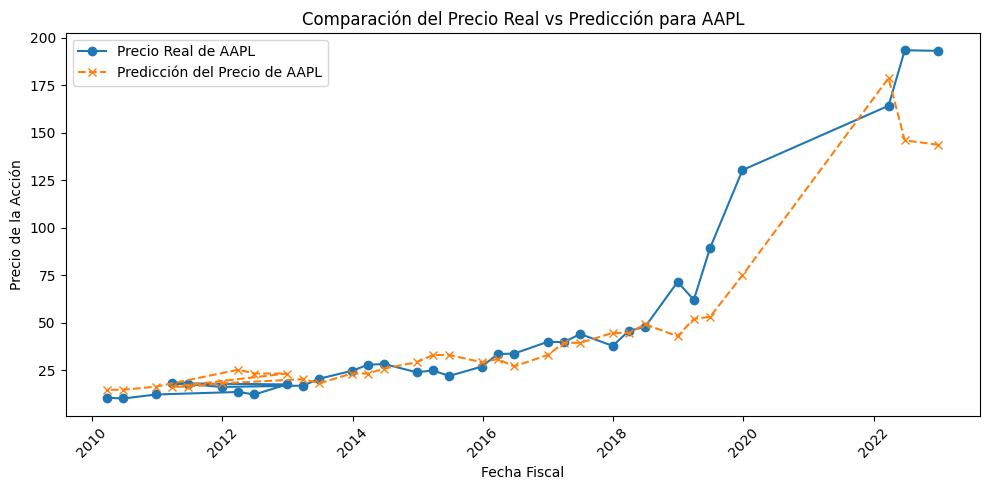

<ipython-input-6-0d124665726b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_symbol['fiscalDateEnding'] = pd.to_datetime(X_symbol['fiscalDateEnding'])


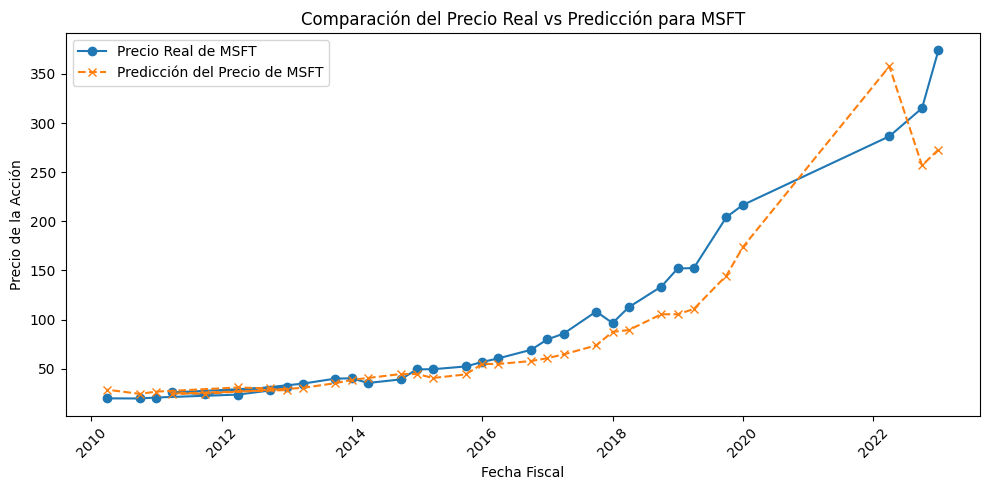

<ipython-input-6-0d124665726b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_symbol['fiscalDateEnding'] = pd.to_datetime(X_symbol['fiscalDateEnding'])


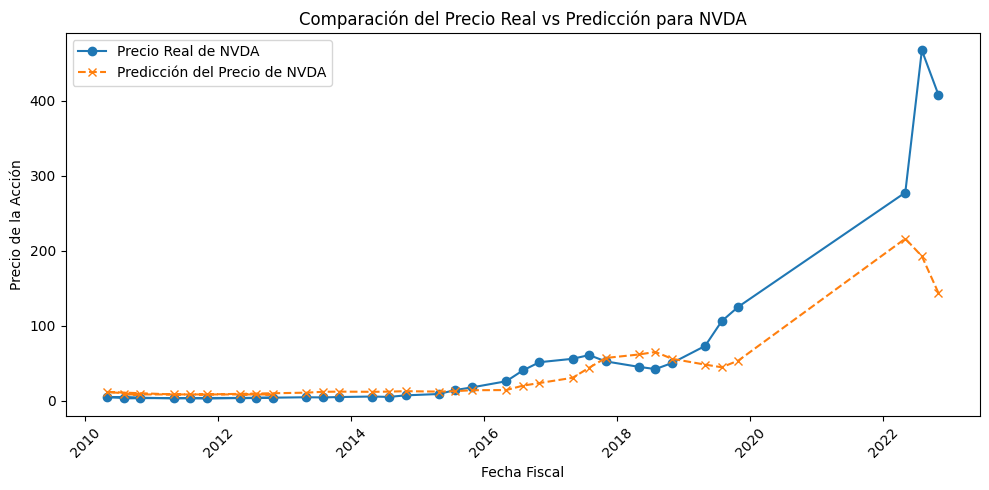

<ipython-input-6-0d124665726b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_symbol['fiscalDateEnding'] = pd.to_datetime(X_symbol['fiscalDateEnding'])


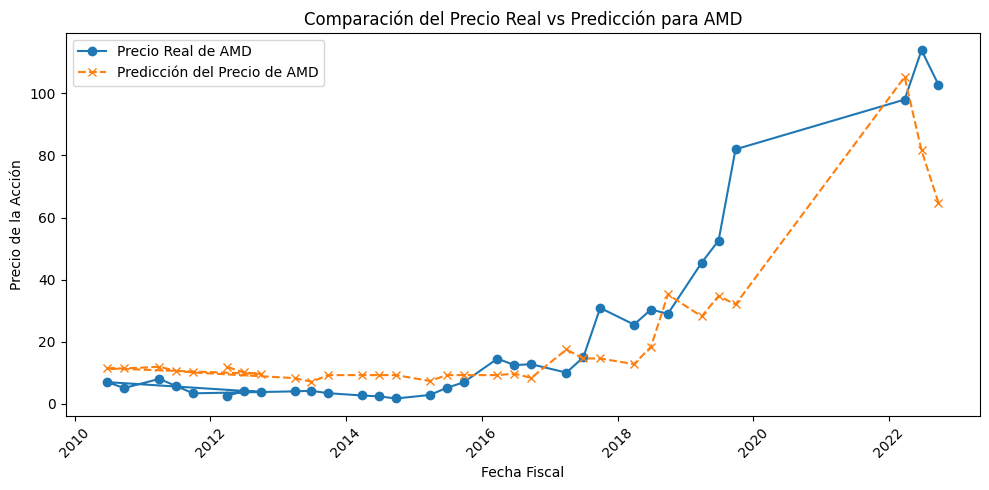

In [ ]:
symbols = ['AAPL', 'MSFT', 'NVDA', 'AMD']
for symbol in symbols:
        # Excluir el símbolo actual de X e y antes de la división TimeSeriesSplit
    X_no_symbol = X[X['symbol'] != symbol].copy()
    y_no_symbol = y[X['symbol'] != symbol].copy()

    # Inicializar TimeSeriesSplit y dividir los datos
    for train_index, test_index in tscv.split(X_no_symbol):
        X_train, X_test = X_no_symbol.iloc[train_index], X_no_symbol.iloc[test_index]
        y_train, y_test = y_no_symbol.iloc[train_index], y_no_symbol.iloc[test_index]

    # Crear y entrenar la pipeline con los datos de entrenamiento que excluyen el símbolo actual
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
    pipeline.fit(X_train, y_train)

    # Hacer predicciones para el símbolo actual
    X_symbol = X[X['symbol'] == symbol]
    y_symbol_real = y[X['symbol'] == symbol]
    y_symbol_pred = pipeline.predict(X_symbol)

    # Asegurarse de que 'fiscalDateEnding' está en formato datetime
    X_symbol['fiscalDateEnding'] = pd.to_datetime(X_symbol['fiscalDateEnding'])

    # Gráfico para el símbolo actual
    plt.figure(figsize=(10, 5))
    plt.plot(X_symbol['fiscalDateEnding'], y_symbol_real, label=f'Precio Real de {symbol}', marker='o')
    plt.plot(X_symbol['fiscalDateEnding'], y_symbol_pred, label=f'Predicción del Precio de {symbol}', linestyle='--', marker='x')
    plt.title(f'Comparación del Precio Real vs Predicción para {symbol}')
    plt.xlabel('Fecha Fiscal')
    plt.ylabel('Precio de la Acción')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Como podemos observar, los modelos predicen correctamente las tendencias en la mayoría de los casos, sin embargo, son poco precisos en el valor concreto predicho.

## Creación de modelos básicos con ajuste de hiperparámetros

En este apartado se estudiará como mejorar los modelos básicos previamente creados mediante la asignación de hiperparámetros. Para ello definiremos los diccionarios de parámetros para cada modelo y se probará a buscar los valores más apropiados mediante la utilización de GridSearch. Al final de esta sección se ejecutarán los modelos con el mismo conjunto de entrenamiento y test que en el caso sin hiperparámetros para poder ver la diferencia real entre usarlos y no. Esto se hace debido a que GridSearch provee como MAE la media de resultados de todos los splits realizados, por tanto no son resultados directamente comparables.

Para comenzar el proceso, definimos nuevamente los datos de entrenamiento y test mediante la utilización de TimeSeriesSplit. Volvemos también a definir el modelo dummy y los modelos, esta vez, indicando además los hiperparámetros que deseamos:

In [ ]:
# Separar la variable objetivo
y = preprocessed_df['1y_sharePrice']
X = preprocessed_df.drop('1y_sharePrice', axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba respetando la temporalidad
tscv = TimeSeriesSplit(n_splits=5).split(X)

# Preparacion del pipeline -> creacion del transformador de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'string']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

Para entender como funciona el time series split:

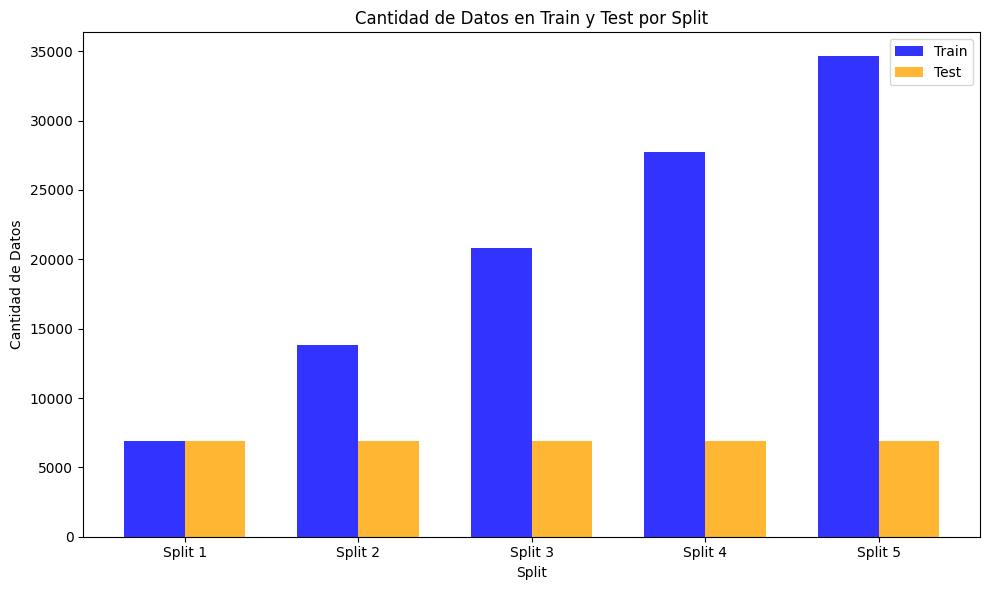

In [ ]:
# Suponiendo que X es tu DataFrame y tscv ya está definido como TimeSeriesSplit(n_splits=5)
tscv = TimeSeriesSplit(n_splits=5)

# Listas para almacenar las cantidades de datos en entrenamiento y prueba
train_sizes = []
test_sizes = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Añadir las cantidades a las listas
    train_sizes.append(len(X_train))
    test_sizes.append(len(X_test))

# Crear el gráfico de barras
n_splits = np.arange(1, len(train_sizes) + 1)
bar_width = 0.35
opacity = 0.8

plt.figure(figsize=(10, 6))
bar1 = plt.bar(n_splits, train_sizes, bar_width, alpha=opacity, color='blue', label='Train')
bar2 = plt.bar(n_splits + bar_width, test_sizes, bar_width, alpha=opacity, color='orange', label='Test')

plt.xlabel('Split')
plt.ylabel('Cantidad de Datos')
plt.title('Cantidad de Datos en Train y Test por Split')
plt.xticks(n_splits + bar_width / 2, [f'Split {i}' for i in range(1, 6)])
plt.legend()

plt.tight_layout()
plt.show()


### KNN
En este modelo, definimos como hiperparámetros el número de vecinos (K: 3, 5 y 7 ya que el default son 5) y la manera de asignar los pesos a los vecinos, por defecto todos iguales (uniform) o en función de la inversa de la distancia (distance).

In [ ]:
model= KNeighborsRegressor()
params = {
    "regressor__n_neighbors": [3, 5, 7],
    "regressor__weights": ['uniform', 'distance']
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"KNN - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

KNN - Mejor MAE: 24.75258001072563 - Mejores parámetros: {'regressor__n_neighbors': 7, 'regressor__weights': 'uniform'} - Tiempo de ejecución (s): 1494.990630865097


El resultado del MAE es ligeramente mejor que empleando los parámetros por defecto. Además, tras comprobar que el mejor método es uniform, y el número de vecinos es el límite superior (7), vamos a probar a buscar con más vecinos, manteniendo los pesos en uniform. A continuación los resultados de las pruebas:

1) K: [7, 9, 11, 13] - Mejor MAE: 23.589983941224812 - Mejores parámetros: {'regressor__n_neighbors': 13} - Tiempo de ejecución (s): 1056.656762599945

2) K: [15, 17, 19] - Mejor MAE: 21.94548527045306 - Mejores parámetros: {'regressor__n_neighbors': 19} - Tiempo de ejecución (s): 776.1186964511871

3) K: [21, 23, 25] - Mejor MAE: 20.952988373895465 - Mejores parámetros: {'regressor__n_neighbors': 25} - Tiempo de ejecución (s): 755.583212852478

4) K: [29, 43, 57] - Mejor MAE: 19.370071800892646 - Mejores parámetros: {'regressor__n_neighbors': 57} - Tiempo de ejecución (s): 757.3912222385406

5) K: [61, 79, 99] - Mejor MAE: 19.320783351999623 - Mejores parámetros: {'regressor__n_neighbors': 79} - Tiempo de ejecución (s): 771.5440111160278

Como podemos comprobar, finalmente hemos llegado a un número de vecinos en el que aumentar el hiperparámetro ya no mejora la precisión. En conclusión, empleando 79 vecinos obtenemos resultados mejores respecto al modelo default, pero no superamos otros modelos como Gradient Boost.

In [ ]:
model= KNeighborsRegressor()
params = {
    "regressor__n_neighbors": [61, 79, 99],
    # "regressor__weights": ['uniform', 'distance']
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"KNN - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

KNN - Mejor MAE: 19.320783351999623 - Mejores parámetros: {'regressor__n_neighbors': 79} - Tiempo de ejecución (s): 771.5440111160278


### Ridge
Este modelo cuenta con un hiperparámetro interesante, alpha, el cual controla la regularización aplicada a la regresión lineal. El default es 1.0. En caso de usar alpha = 0 estaríamos recurriendo a una regresión lineal por defecto.

In [ ]:
model= Ridge(random_state=42)
params = {
    "regressor__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Ridge - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Ridge - Mejor MAE: 23.482362468131793 - Mejores parámetros: {'regressor__alpha': 10.0} - Tiempo de ejecución (s): 6.352652311325073


Podemos comprobar que toma el alpha = 10 como mejor resultado, probaremos con valores cercanos al mismo para intentar mejorar la precisión del modelo:

1) Alpha: [5:15] - Mejor MAE: 23.479211520335973 - Mejores parámetros: {'regressor__alpha': 11} - Tiempo de ejecución (s): 9.899832248687744

2) Alpha: [10:12, step 0.2] - Mejor MAE: 23.47908425037538 - Mejores parámetros: {'regressor__alpha': 10.8} - Tiempo de ejecución (s): 10.786231994628906

In [ ]:
model= Ridge(random_state=42)
params = {
    "regressor__alpha": [i for i in np.arange(10, 12.2, 0.2)]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Ridge - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Ridge - Mejor MAE: 23.47908425037538 - Mejores parámetros: {'regressor__alpha': 10.799999999999997} - Tiempo de ejecución (s): 10.786231994628906


### Lasso
En este modelo, también modificamos el parámetro alpha, cuyo valor por defecto también es 1.0.

In [ ]:
model= Lasso(random_state=42)
params = {
    "regressor__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Lasso - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Lasso - Mejor MAE: 20.782505415454384 - Mejores parámetros: {'regressor__alpha': 0.1} - Tiempo de ejecución (s): 13.463841199874878


En este caso obtenemos como mejor resultado alpha = 0.1; por tanto probaremos con valores cercanos al mismo:

1) Alpha: [0.05:1, step 0.05] - Mejor MAE: 20.47836400317349 - Mejores parámetros: {'regressor__alpha': 0.15} - Tiempo de ejecución (s): 64.5625593662262


In [ ]:
model= Lasso(random_state=42)
params = {
    "regressor__alpha": [i for i in np.arange(0.05, 1, 0.05)]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Lasso - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Lasso - Mejor MAE: 20.47836400317349 - Mejores parámetros: {'regressor__alpha': 0.15000000000000002} - Tiempo de ejecución (s): 64.5625593662262


### Decision Tree
En este modelo trataremos de modificar la profundidad máxima de nodos, siendo por defecto none, y el número mínimo de muestras para dividir un nodo, por defecto 2.

In [ ]:
model= DecisionTreeRegressor(random_state=42)
params = {
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 10]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Decision Tree - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Decision Tree - Mejor MAE: 15.702469511701405 - Mejores parámetros: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10} - Tiempo de ejecución (s): 242.01576924324036


Como podemos comprobar, en este modelo sí conseguimos obtener mejores resultados directamente respecto al modelo sin hiperparámetros. Vamos a continuar con la investigación para hallar qué valores son los más apropiados:

1) depth:[8, 10, 12, 14]; min_samples:[10, 15, 20] -  Decision Tree - Mejor MAE: 15.112113627804977 - Mejores parámetros: {'regressor__max_depth': 8, 'regressor__min_samples_split': 20} - Tiempo de ejecución (s): 45.80090069770813

2) depth:[2, 4, 6, 8, 9]; min_samples:[20, 25, 30, 35] - Decision Tree - Mejor MAE: 14.90731928673146 - Mejores parámetros: {'regressor__max_depth': 6, 'regressor__min_samples_split': 35} - Tiempo de ejecución (s): 45.84209442138672

3) depth:[5, 6, 7, 8]; min_samples: [32, 35, 38, 41] - Decision Tree - Mejor MAE: 14.846547888327095 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 35} - Tiempo de ejecución (s): 29.170167684555054

En conclusión, podemos ver que ha mejorado ligeramente la precisión gracias a una profundidad de 7 y un mínimo de muestras por nodo de 35.

In [ ]:
model= DecisionTreeRegressor(random_state=42)
params = {
    "regressor__max_depth": [5, 6, 7, 8],
    "regressor__min_samples_split": [32, 35, 38, 41]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Decision Tree - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Decision Tree - Mejor MAE: 14.846547888327095 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 35} - Tiempo de ejecución (s): 36.887702226638794


### Random Forest
En este modelo los hiperparámetros a modificar son el número de etapas o estimadores, siendo por defecto 100 y obteniendo mejores resultados con mayor número; profundidad máxima, cuyo valor predeterminado es None; y el número mínimo de muestras para dividir un nodo, por defecto 2.

In [ ]:
model= RandomForestRegressor(random_state=42)
params = {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [None, 10],
            "regressor__min_samples_split": [2, 5]
        }

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Random Forest - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Tras realizar un primer acercamiento podemos comprobar que el modelo se beneficia de tener fija la profundidad máxima y que el numero de estimadores, así como de min_samples_split, será beneficioso con valores más grandes.

1) Stimators: [100, 150], max_depth: [5, 10, 15], min_samples_split: [5, 7] - Mejor MAE: 13.903560993661774 - Mejores parámetros: {'regressor__max_depth': 10, 'regressor__min_samples_split': 7, 'regressor__n_estimators': 150} - Tiempo de ejecución (s): 3549.9993693828583

2) Stimators: [150, 250], max_depth: [7, 10], min_samples_split: [30, 35] - Mejor MAE: 13.799813755483111 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 30, 'regressor__n_estimators': 250} - Tiempo de ejecución (s): 2677.5397398471832

3) Stimators: [250], max_depth: [6, 7, 8, 9], min_samples_split: [30] - Mejor MAE: 13.799813755483111 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 30, 'regressor__n_estimators': 250} - Tiempo de ejecución (s): 1457.8478746414185

Tras comprobar que la máxima profundidad optima es 7, vamos a comprobar el valor óptimo para n_stimators:

4) N_stimators: [250, 350, 450] - Mejor MAE: 13.789408327660007 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 30, 'regressor__n_estimators': 450} - Tiempo de ejecución (s): 1516.2473039627075

5) N_stimators: [550:950, step 100] - Mejor MAE: 13.780136100457517 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 30, 'regressor__n_estimators': 850} - Tiempo de ejecución (s): 4954.124004125595

Tras haber encontrado un número de estimadores que no mejora más el modelo, queda por encontrar las muestras mínimas necesarias para realizar una división:

6) min_samples_split: [35:55, step 5] - Mejor MAE: 13.781047309290622 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 35, 'regressor__n_estimators': 850} - Tiempo de ejecución (s): 5577.264385461807

7) min_samples_split: [30:34, step 1] - Mejor MAE: 13.779780090643495 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 31, 'regressor__n_estimators': 850} - Tiempo de ejecución (s): 4285.223886489868

In [ ]:
model= RandomForestRegressor(random_state=42)
params = {
            "regressor__n_estimators": [850],
            "regressor__max_depth": [7],
            "regressor__min_samples_split": [i for i in range(30, 34, 1)]
        }

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Random forest - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Random forest - Mejor MAE: 13.779780090643495 - Mejores parámetros: {'regressor__max_depth': 7, 'regressor__min_samples_split': 31, 'regressor__n_estimators': 850} - Tiempo de ejecución (s): 4285.223886489868


### Gradient Boosting

En este caso los hiperparámetros a modificar son también el número de etapas o estimadores, siendo por defecto 100; la profundidad máxima, siendo por defecto 3; y la tasa de aprendizaje, por defecto 0.1 . En este método el parámetro más determinante es el learning rate, por lo tanto, será el primero en ser ajustado.

In [ ]:
model= GradientBoostingRegressor(random_state=42)
params = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__learning_rate": [0.01, 0.1, 0.2],
    "regressor__max_depth": [3, 5, 7]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Gradient Boosting - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Gradient Boosting - Mejor MAE: 13.800843339173394 - Mejores parámetros: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100} - Tiempo de ejecución (s): 5803.383812665939


Como podemos comprobar, el tiempo de entrenamiento ha sido muy largo y no hemos obtenido resultados mejores en comparación al modelo sin hiperparametrizar (nota: como ha sido comentado al principio esto puede ser causado por la manera de calcular la precisión que tiene el GridSearch, no indica directamente que ofrezca peor precisión). Por tanto, a continuación probaremos a modificar únicamente el learning rate:

1) L.Rate: [0.05:0.15, step 0.01], stimators: 100, depth: 5 - Mejor MAE: 13.799972117504279 - Mejores parámetros: {'regressor__learning_rate': 0.07, 'regressor__max_depth': 5, 'regressor__n_estimators': 100} - Tiempo de ejecución (s): 1079.6079154014587

Hemos conseguido un Learning Rate dentro del rango estudiado y tampoco ha mejorado, por tanto, probaremos a estudiar el cambio en n_stimators:

2) L.Rate: [0.07:0.11, step 0.01], stimators: [50, 100, 150], depth: 5 Mejor MAE: 13.782845738512842 - Mejores parámetros: {'regressor__learning_rate': 0.07, 'regressor__max_depth': 5, 'regressor__n_estimators': 150} - Tiempo de ejecución (s): 1327.3425948619843

3) L.Rate: [0.05, 0.07, 0.10], stimators: [150, 200, 250], depth: 5 - Mejor MAE: 13.782845738512842 - Mejores parámetros: {'regressor__learning_rate': 0.07, 'regressor__max_depth': 5, 'regressor__n_estimators': 150} - Tiempo de ejecución (s): 1891.776706457138

Como podemos ver, la hiperparametrización no nos está dando mejores resultados, vamos a probar con valores más cercanos al learning rate y estimadores obtenidos hasta ahora gracias al GridSearch (0.07 y 150), además vamos a emplear los valores que encontramos útiles en decision tree regressor para comprobar su efectividad.

4) Mejor MAE: 13.905685342257922 - Mejores parámetros: {'regressor__learning_rate': 0.065, 'regressor__max_depth': 7, 'regressor__min_samples_split': 35, 'regressor__n_estimators': 125} - Tiempo de ejecución (s): 1993.7523519992828

Debido a que tampoco mejora, probamos con valores cercanos a los hayados anteriormente en L.rate y n_stimators, 0.07 y 150 respectivamente:

5) n_stimators: [125:165, step 5], l.rate: [0.06:0.08, step 0.005] - Mejor MAE: 14.008901588159683 - Mejores parámetros: {'regressor__learning_rate': 0.07500000000000001, 'regressor__n_estimators': 155} - Tiempo de ejecución (s): 3616.052302122116

6) n_stimators: [145:165, step 5], l.rate: [0.075:0.095, step 0.005] - Mejor MAE: 14.013962961008508 - Mejores parámetros: {'regressor__learning_rate': 0.075, 'regressor__n_estimators': 155} - Tiempo de ejecución (s): 2071.4322476387024


In [ ]:
model= GradientBoostingRegressor(random_state=42)
params = {
    "regressor__n_estimators": [i for i in range(145, 165, 5)],
    "regressor__learning_rate": [i for i in np.arange(0.075, 0.095, 0.005)]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Gradient Boosting - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Gradient Boosting - Mejor MAE: 14.013962961008508 - Mejores parámetros: {'regressor__learning_rate': 0.075, 'regressor__n_estimators': 155} - Tiempo de ejecución (s): 2071.4322476387024


### Adaboost

En este modelo como en Gradient Boosting tenemos número de estimadores y tasa de aprendizaje, siendo por defecto 50 y 1.0 respectivamente.

In [ ]:
model= AdaBoostRegressor(random_state=42)
params = {
    "regressor__n_estimators": [50, 100, 200],
    "regressor__learning_rate": [0.01, 0.1, 1.0]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Adaboost - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Adaboost - Mejor MAE: 15.79429157011217 - Mejores parámetros: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 50} - Tiempo de ejecución (s): 560.0575559139252


En este modelo hemos mejorado los resultados que nos ofrecía el modelo sin parametrizar, sin embargo, todavía podemos mejorarlos ya que como puede verse, hemos empleado el límite inferior en ambos parámetros.

1) n_timators: [20:50, step 5], l.rate: [0.005:0.03, step 0.005] - Mejor MAE: 15.710300094650691 - Mejores parámetros: {'regressor__learning_rate': 0.025, 'regressor__n_estimators': 25} - Tiempo de ejecución (s): 1061.4149310588837

Como podemos observar, los parámetros obtenidos ya no se encuentran en los límites de sus rangos, por tanto, podemos frenar ya la búsqueda.

In [ ]:
model= AdaBoostRegressor(random_state=42)
params = {
    "regressor__n_estimators": [i for i in range(20, 55, 5)],
    "regressor__learning_rate": [i for i in np.arange(0.005, 0.03, 0.005)]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"Adaboost - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Adaboost - Mejor MAE: 15.710300094650691 - Mejores parámetros: {'regressor__learning_rate': 0.025, 'regressor__n_estimators': 25} - Tiempo de ejecución (s): 1061.4149310588837


### SVR

En este modelo tenemos como hiperparámetros principales el kernel, por defecto rbf; y el parámetro de regularización C, por defecto 1.0.

In [ ]:
model= SVR()
params = {
    "regressor__C": [0.1, 1, 10],
    "regressor__kernel": ['linear', 'rbf', 'sigmoid', 'poly']
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"SVR - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

SVR - Mejor MAE: 20.353091051554483 - Mejores parámetros: {'regressor__C': 10, 'regressor__kernel': 'linear'} - Tiempo de ejecución (s): 4015.4659581184387


Como podemos comprobar, la máquina de vector de soporte con un kernel linear nos da resultados mejores que en el modelo por defecto. A continuación, estudiaremos los distintos valores de C para este kernel:

1) Kernel: ['linear'], C: [5:15] - Mejor MAE: 20.353091051554483 - Mejores parámetros: {'regressor__C': 10, 'regressor__kernel': 'linear'} - Tiempo de ejecución (s): 3852.575447320938

In [ ]:
model= SVR()
params = {
    "regressor__C": [i for i in range(5, 16)],
    "regressor__kernel": ['linear']
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"SVR - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

SVR - Mejor MAE: 20.353091051554483 - Mejores parámetros: {'regressor__C': 10, 'regressor__kernel': 'linear'} - Tiempo de ejecución (s): 3852.575447320938


### XGBoost

En este modelo contamos con parámetros muy similares a aquellos vistos anteriormente en otros ensenbles, 'eta' sigue refiriendose a la tasa de aprendizaje.

In [ ]:
model= XGBRegressor(random_state=42)
params = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__eta": [0.01, 0.1, 0.2],
    "regressor__max_depth": [3, 5, 7]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"XGBoost - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

XGBoost - Mejor MAE: 14.024119988234194 - Mejores parámetros: {'regressor__eta': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100} - Tiempo de ejecución (s): 342.81867265701294


Como podemos ver, hemos podido encontrar ya valores de 'eta' y 'max_depth' cercanos al óptimo. Por tanto continuaremos la búsqueda por valores cercanos a los encontrados:

1) n_stimators: [50:140, step 10], eta: [0.05:0.15, step 0.01], max_depth: [4, 5, 6] - Mejor MAE: 13.946221835027035 - Mejores parámetros: {'regressor__eta': 0.13, 'regressor__max_depth': 4, 'regressor__n_estimators': 100} - Tiempo de ejecución (s): 1850.7177209854126

In [ ]:
model= XGBRegressor(random_state=42)
params = {
    "regressor__n_estimators": [i for i in range(50, 150, 10)],
    "regressor__eta": [i for i in np.arange(0.05, 0.16, 0.01)],
    "regressor__max_depth": [4, 5, 6]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"XGBoost - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

XGBoost - Mejor MAE: 13.946221835027035 - Mejores parámetros: {'regressor__eta': 0.13, 'regressor__max_depth': 4, 'regressor__n_estimators': 100} - Tiempo de ejecución (s): 1850.7177209854126


### LightGBM

Este modelo cuenta con un funcionamiento y una hiperparametrización igual a la de otros ensembles.

In [ ]:
model= LGBMRegressor(random_state=42, verbose=-1)
params = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__learning_rate": [0.01, 0.1, 0.2],
    "regressor__max_depth": [-1, 5, 10]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"LightGBM - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

Como podemos comprobar, LightGBM entrena muy rápido los modelos, por tanto podemos probar más combinaciones de hiperparámetros en menor tiempo. A continuación probaremos a utilizar rangos cercanos a los resultados ya obtenidos:

1) n_stimators: [300, 400, 500], l.rate: [0.005:0.3, 0.05] m.depth: [3, 7] - Mejor MAE: 14.12272114483336 - Mejores parámetros: {'regressor__learning_rate': 0.055, 'regressor__max_depth': 3, 'regressor__n_estimators': 300} - Tiempo de ejecución (s): 586.1843998432159

2) n_stimators: [1:300, step 10], l.rate: [0.005:0.3, step 0.05] m.depth: [3:7] - Mejor MAE: 13.93029561254221 - Mejores parámetros: {'regressor__learning_rate': 0.055, 'regressor__max_depth': 4, 'regressor__n_estimators': 131} - Tiempo de ejecución (s): 2826.687821149826





In [ ]:
model= LGBMRegressor(random_state=42, verbose=-1)
params = {
    "regressor__n_estimators": [i for i in range(1, 300, 10)],
    "regressor__learning_rate": [i for i in np.arange(0.005, 0.3, 0.05)],
    "regressor__max_depth": [4]
}

start_t = time.time()
# Crear una pipeline con el preprocesador y el clasificador
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),  # with_mean=False para manejar matrices dispersas
    ('regressor', model)
])

# Ejemplo de uso con GridSearchCV
model_cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=tscv, scoring='neg_mean_absolute_error')
model_cv.fit(X, y)

end_t = time.time()
best_score = -model_cv.best_score_
best_params = model_cv.best_params_

print(f"LightGBM - Mejor MAE: {best_score} - Mejores parámetros: {best_params} - Tiempo de ejecución (s): {end_t - start_t}")

LightGBM - Mejor MAE: 13.93029561254221 - Mejores parámetros: {'regressor__learning_rate': 0.055, 'regressor__max_depth': 4, 'regressor__n_estimators': 131} - Tiempo de ejecución (s): 490.8651020526886


### Resultados GridSearch

Tras llevar a cabo la hiperparametrización de los diferentes modelos hemos conseguido averiguar de qué manera optimizar cada uno de los métodos de aprendizaje supervisado, a continuación se muestran los valores idóneos para cada configuración:

| Modelos          | Parámetros                              | MAE  |
|------------------|-----------------------------------------|------|
| KNN              | 'n_neighbors': 79, 'weights': uniform   |19.32 |
| Ridge            | 'alpha': 10.8                           |23.47 |
| Lasso            | 'alpha': 0.15                           |20.47 |
| Decision Tree    | 'max_depth': 7, 'min_samples_split': 35 |14.84 |
| Random Forest    | 'max_depth': 7, 'min_samples_split': 31, 'n_estimators': 850                                                          |13.78 |
| GradientBoosting | 'learning_rate': 0.07, 'n_estimators': 150, 'max_depth': 5                                                            |13.78 |
| Adaboost         | 'learning_rate': 0.01, 'n_estimators': 5|15.71 |
| SVR              | 'C': 10, 'kernel': 'linear'             |20.35 |
| XGBoost          | 'eta': 0.13, 'max_depth': 4, 'n_estimators': 100 |13.95 |
| LightGBM         | 'learning_rate': 0.055, 'n_estimators': 131, 'max_depth': 4 |13.93 |





## Modelos básicos vs modelos parametrizados

Tras haber realizado una sólida investigación para encontrar los valores más idóneos para cada modelo, procedemos a ejecutarlos y evaluarlos en las mismas condiciones que los modelos por defecto, de esta manera podremos conocer cual es el modelo que mejor se comporta ante nuestro problema.

In [ ]:
# Separar la variable objetivo
y = preprocessed_df['1y_sharePrice']
X = preprocessed_df.drop('1y_sharePrice', axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba respetando la temporalidad
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Creamos un modelo dummy para usar como benchmark
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_dummy_pred = dummy_regr.predict(X_test)
dummy_MAE = metrics.mean_absolute_error(y_test, y_dummy_pred)
print(f"Dummy regressor MAE: {dummy_MAE}")

# Preparacion del pipeline -> creacion del transformador de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'string']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Diccionario de modelos a desarrollar
models = {
    "knn": KNeighborsRegressor(n_neighbors=79),
    "ridge": Ridge(alpha=10.8, random_state=42),
    "lasso": Lasso(alpha=0.15, random_state=42),
    "decision_tree": DecisionTreeRegressor(max_depth=7, min_samples_split=35, random_state=42),
    "random_forest": RandomForestRegressor(max_depth=7, min_samples_split=31, n_estimators=850, random_state=42),
    "gradient_boosting": GradientBoostingRegressor(learning_rate=0.07, n_estimators=150, max_depth=5, random_state=42),
    "adaboost": AdaBoostRegressor(learning_rate=0.01, n_estimators=5, random_state=42),
    "svr": SVR(C=10, kernel='linear'),
    "xgboost": XGBRegressor(eta=0.13, max_depth=4, n_estimators=100, random_state=42),
    "lightgbm": LGBMRegressor(learning_rate=0.055, n_estimators=131, max_depth=4, random_state=42, verbose=-1),
}

print(f'Media de precios: {preprocessed_df["1y_sharePrice"].mean()}')

for model in models:
  start_t = time.time()
  # Crear una pipeline con el preprocesador y el clasificador
  pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('scaler', MaxAbsScaler()),
      ('regressor', models[model])
  ])

  # Entrenar el modelo y realizar predicciones
  pipeline.fit(X_train, y_train)
  y_predict = pipeline.predict(X_test)
  end_t = time.time()

  # Comprobamos el MAE respecto al dummy regressor
  MAE = metrics.mean_absolute_error(y_test, y_predict)
  diff_MAE = (dummy_MAE - MAE)*100 / dummy_MAE
  print(f"{model} MAE: {MAE}  --  mejora respecto a dummy: {diff_MAE}  --  Tiempo de ejecucion (s): {end_t - start_t}")


Dummy regressor MAE: 34.17534043736865
Media de precios: 38.954854550048125
knn MAE: 14.549688493733028  --  mejora respecto a dummy: 57.42635389280911  --  Tiempo de ejecucion (s): 84.76317024230957
ridge MAE: 18.183574123743995  --  mejora respecto a dummy: 46.79329045143508  --  Tiempo de ejecucion (s): 0.13534832000732422
lasso MAE: 17.538423110148763  --  mejora respecto a dummy: 48.681058079610025  --  Tiempo de ejecucion (s): 0.9955503940582275
decision_tree MAE: 13.461678983288872  --  mejora respecto a dummy: 60.609963760392134  --  Tiempo de ejecucion (s): 0.5228710174560547
random_forest MAE: 12.520038380374185  --  mejora respecto a dummy: 63.36528555342703  --  Tiempo de ejecucion (s): 264.6329207420349
gradient_boosting MAE: 12.380787740670016  --  mejora respecto a dummy: 63.77274496106443  --  Tiempo de ejecucion (s): 43.56918025016785
adaboost MAE: 14.978954923640194  --  mejora respecto a dummy: 56.17028321607698  --  Tiempo de ejecucion (s): 1.0704939365386963
svr MA

Como podemos ver, el modelo que mejor se comporta en este caso es gradient boosting, con un MAE de 12.38$.

A continuación podemos ver una tabla comparativa de los errores medios absolutos de cada modelo básico vs hiperparametrizado:

| Modelos          | MAE (Default)     | MAE (Hiperparametrizado)  |
|------------------|-------------------|---------------------------|
| KNN              | 27.50             | 14.55                     |
| Linear Regression| 27.24             | x                         |
| Ridge            | 23.03             | 18.18                     |
| Lasso            | 20.18             | 17.53                     |
| Decision Tree    | 17.10             | 13.46                     |
| Random Forest    | 12.79             | 12.52                     |
| GradientBoosting | 12.85             | 12.38                     |
| Adaboost         | 19.94             | 14.98                     |
| SVR              | 25.16             | 16.03                     |
| XGBoost          | 13.20             | 12.74                     |
| LightGBM         | 13.06             | 12.57                     |

En definitiva, podemos ver que la hiperparametrización ha sido muy conveniente en algunos modelos, destacando la mejora de SVR y KNN; sin embargo, en el caso de los ensembles no se logra obtener una mejora muy significativa. A pesar de ello, siguen siendo los modelos con mejores resultados.

## Modelos de redes de neuronas

En la siguiente sección investigaremos sobre la creación de modelos empleando redes de neuronas. Probaremos con diferentes métodos y compararemos los resultados con aquellos obtenidos anteriormente con los modelos básicos e hiperparametrizados.

Al igual que en el desarrollo de modelo, debemos aplicar una serie de transformaciones que preparen lo datos, además al tratarse de redes neuronales debemos definir las secuencias de datos, es decir, la ventana de datos que se empleará para llevar a cabo la predicción.

In [ ]:
# Separar las columnas objetivo y características
preprocessed_df.sort_values(by=['symbol', 'fiscalDateEnding'], inplace=True)
preprocessed_df.reset_index(drop=True, inplace=True)
y = preprocessed_df['1y_sharePrice']
X = preprocessed_df.drop(['fiscalDateEnding', '1y_sharePrice', 'symbol'], axis=1) # Eliminamos el symbolo porque genera demasiadas caracteristicas

# Preparar el transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.select_dtypes(include=['float64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sector'])
    ])

# Aplicamos el preprocesador a X y convertimos el resultado a array denso
X_processed = preprocessor.fit_transform(X)

# Función para crear secuencias
def create_sequences(X, y, sequence_length):
    X_seqs, y_seqs = [], []
    print(X)
    for i in range(len(X) - sequence_length):
        X_seqs.append(X[i:(i + sequence_length)])
        y_seqs.append(y[i + sequence_length])
    return np.array(X_seqs), np.array(y_seqs)

# Crear secuencias
sequence_length = 5
X_seqs, y_seqs = create_sequences(X_processed, y.values, sequence_length)

# División en conjuntos de entrenamiento y prueba
split_point = int(len(X_seqs) * 0.8)
X_train, X_test = X_seqs[:split_point], X_seqs[split_point:]
y_train, y_test = y_seqs[:split_point], y_seqs[split_point:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


[[ 0.          0.          0.         ...  1.          0.
   0.        ]
 [-0.15273784 -0.11004345 -0.10946633 ...  1.          0.
   0.        ]
 [-0.15262633 -0.11004345 -0.10980956 ...  1.          0.
   0.        ]
 ...
 [-0.14757916 -0.11001208 -0.21493387 ...  0.          0.
   0.        ]
 [-0.14985285 -0.11004344 -0.11018376 ...  1.          0.
   0.        ]
 [-0.14982294 -0.11004344 -0.11023753 ...  1.          0.
   0.        ]]
(33244, 5, 24) (8311, 5, 24) (33244,) (8311,)


Primero investigaremos las redes de neuronas de tipo LSTM, las cuales pueden ofrecernos buenos resultados para la predicción de series temporales. Comenzamos definiendo un sencillo modelo con una capa de 50 neuronas, función de activación relu, 10 epochs y un batch size de 64.

In [ ]:
# Definir la arquitectura del modelo
model = Sequential([
    # Primera capa LSTM
    LSTM(units=50, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    # Capa de salida
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_absolute_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluar el modelo
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss}')


Epoch 1/10
520/520 [==============================] - 3s 3ms/step - loss: 28.7840 - val_loss: 24.0454
Epoch 2/10
520/520 [==============================] - 1s 3ms/step - loss: 22.3758 - val_loss: 22.0173
Epoch 3/10
520/520 [==============================] - 2s 3ms/step - loss: 20.9523 - val_loss: 21.0275
Epoch 4/10
520/520 [==============================] - 2s 3ms/step - loss: 20.0070 - val_loss: 21.3325
Epoch 5/10
520/520 [==============================] - 2s 3ms/step - loss: 19.3579 - val_loss: 20.1818
Epoch 6/10
520/520 [==============================] - 2s 4ms/step - loss: 18.8490 - val_loss: 19.9453
Epoch 7/10
520/520 [==============================] - 1s 3ms/step - loss: 18.5504 - val_loss: 19.7570
Epoch 8/10
520/520 [==============================] - 2s 3ms/step - loss: 18.2284 - val_loss: 19.2457
Epoch 9/10
520/520 [==============================] - 2s 3ms/step - loss: 18.0528 - val_loss: 19.1046
Epoch 10/10
260/260 [==============================] - 0s 2ms/step - loss: 19.3192

Como podemos ver los resultados no son muy buenos (MAE: 19.31$), sin embargo, llevaremos a cabo diferentes transformaciones al modelo para poder mejorar estos resultados.

Comenzaremos modificando la arquitectura del modelo, en esta arquitectura probaremos con diferentes configuraciones de capas LSTM:

units_options = [[50, 100, 150], [50, 100, 150]] - MAE: 18.806350708007812, Best combination: (150, 50)

units_ options = [[150], [25, 50], [25, 50, 100]] - MAE: 18.678817749023438, Best combination: (150, 25, 25)

units_options = [[150], [10, 25], [10, 25]] - MAE: 18.717117309570312, Best combination: (150, 10, 10)

units_options = [[150], [20], [20], [20]]  - MAE: 19.089496612548828, Best combination: (150, 20, 20, 20)

Como podemos comprobar, agregar más capas ya no nos ofrece mejor rendimiento. Y el número de neuronas por capa no varía tampoco. Por tanto, ahora probaremos a agregar jornadas de dropout a las capas ocultas, para comprobar si el modelo puede estar siendo afectado por sobreentrenamiento.

Capas: 150, 20, 20; Dropout: 0.1 - MAE: 18.849729537963867, Best combination: (150, 20, 20)

Capas: 150, 20, 20; Dropout: 0.2 - MAE: 18.944103240966797, Best combination: (150, 20, 20)

Debido a que el dropout no nos aporta mayor precisión, vamos a probar a cambiar las funciones de activación de las capas (antes hemos utilizado en todas relu):


Capas: 150 (relu), 20 (tanh), 20 (tanh) - MAE: 18.762306213378906, Best combination: (150, 20, 20)

Capas: 150 (tanh), 20 (tanh), 20 (tanh) - MAE: 18.831974029541016, Best combination: (150, 20, 20)


Empleando funciones de activación diferentes, como tanh tampoco conseguimos mejores resultados. A continuación probaremos a agregar regularización L2, probaremos con diferentes valores y probaremos a agregar más capas para intentar capturar mayor complejidad, a estas les aplicaremos mayores términos de regularización para evitar overfitting:

units_options = [[150], [20], [20]]; l2: 0.01 - MAE: 20.34986114501953, Best combination: (150, 20, 20)

Como podemos comprobar la regularización no nos aporta buenos resultados tampoco.

In [ ]:
def build_model(layers_units):
    """Construye el modelo basado en una lista de unidades por capa."""
    model = Sequential()
    for i, units in enumerate(layers_units):
        print(f'capa{i+1}: {units} - {layers_units}')
        return_sequences = i < len(layers_units) - 1  # True para todas menos la última capa LSTM
        if i == 0:
            model.add(LSTM(units=units, activation='relu', return_sequences=return_sequences,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units=units, activation='relu', return_sequences=return_sequences))
            # model.add(Dropout(0.2))
    model.add(Dense(1))  # Capa de salida
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_and_evaluate_model(layers_units):
    """Entrena y evalúa el modelo."""
    model = build_model(layers_units)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
    test_loss = model.evaluate(X_test, y_test)
    return test_loss

# Especificación de las unidades para cada: [[capa1], [capa2] ... [capaN]]
units_options = [[150], [25], [25]]

# Generación de todas las combinaciones posibles de unidades
all_combinations = list(product(*units_options))
best_mae = np.inf
best_combination = None

# Bucle para entrenar y evaluar cada combinación
for combination in all_combinations:
    print(f'Evaluando combinación:')
    test_loss = train_and_evaluate_model(combination)
    print(f'Test Loss (MSE): {test_loss} - Combination: {combination}\n\n')
    if test_loss < best_mae:
        best_mae = test_loss
        best_combination = combination

print(f'MAE: {best_mae}, Best combination: {best_combination}')


Evaluando combinación:
capa1: 150 - (150, 25, 25)
capa2: 25 - (150, 25, 25)
capa3: 25 - (150, 25, 25)
Epoch 1/200
520/520 [==============================] - 9s 13ms/step - loss: 27.6243 - val_loss: 22.6447
Epoch 2/200
520/520 [==============================] - 6s 11ms/step - loss: 22.3998 - val_loss: 21.6645
Epoch 3/200
520/520 [==============================] - 6s 12ms/step - loss: 20.0634 - val_loss: 19.8577
Epoch 4/200
520/520 [==============================] - 6s 11ms/step - loss: 19.2375 - val_loss: 20.0172
Epoch 5/200
520/520 [==============================] - 7s 14ms/step - loss: 18.7077 - val_loss: 19.1611
Epoch 6/200
520/520 [==============================] - 6s 11ms/step - loss: 18.1840 - val_loss: 19.4594
Epoch 7/200
520/520 [==============================] - 6s 12ms/step - loss: 18.5363 - val_loss: 19.6104
Epoch 8/200
520/520 [==============================] - 6s 11ms/step - loss: 17.8372 - val_loss: 18.9724
Epoch 9/200
520/520 [==============================] - 6s 12ms/ste

Debido a que los resultados hasta ahora no han sido satisfactorios, vamos a probar a mezclaz capas LSTM con capas densas:

unit_options = [[150]LSTM, [20, 50, 100]D, [20, 50, 100]D] - MAE: 18.547462463378906, Best combination: (150, 50, 100)

unit_options = [[100, 150]D, [20, 50]LSTM, [20, 50]LSTM] - MAE: 18.618072509765625, Best combination: (150, 50, 50)

Tras probar con otras como Conv1D (efectivas en algunos problemas de regresión) y MaxPooling (efectivas en reducción de dimensionalidad) no obtenemos resultados buenos. Por tanto, ya que LSTM y su combinación con otros tipos de capas no otorgan buenos resultados, probaremos a utilizar otros tipos de redes como GRU:

GRU: [[100, 150], [20,50], [20,50]]  - MAE: 18.535097122192383, Best combination: (100, 50, 20)

GRU: [[50, 100, 150, 200]] - MAE: 19.096721649169922, Best combination: (100,)

Finalmente, usando capas GRU tampoco conseguimos resultados concluyentes. Por tanto, podemos confirmar que en este caso concreto, debido a la estructura de los datos no podemos usar redes neuronales para la predicción de precios.







In [ ]:
def build_model(layers_units):
    """Construye el modelo basado en una lista de unidades por capa."""
    model = Sequential()
    for i, units in enumerate(layers_units):
        print(f'capa{i+1}: {units} - {layers_units}')
        return_sequences = i < len(layers_units) - 1  # True para todas menos la última capa LSTM
        if i == 0:
            model.add(GRU(units=units, activation='relu', return_sequences=return_sequences,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(GRU(units=units, activation='relu', return_sequences=return_sequences))
    model.add(Dense(1))  # Capa de salida
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_and_evaluate_model(layers_units):
    """Entrena y evalúa el modelo."""
    model = build_model(layers_units)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])
    test_loss = model.evaluate(X_test, y_test)
    return test_loss

# Especificación de las unidades para cada: [[capa1], [capa2] ... [capaN]]
units_options = [[50, 100, 150, 200]]

# Generación de todas las combinaciones posibles de unidades
all_combinations = list(product(*units_options))
best_mae = np.inf
best_combination = None

# Bucle para entrenar y evaluar cada combinación
for combination in all_combinations:
    print(f'Evaluando combinación:')
    test_loss = train_and_evaluate_model(combination)
    print(f'Test Loss (MSE): {test_loss} - Combination: {combination}\n\n')
    if test_loss < best_mae:
        best_mae = test_loss
        best_combination = combination

print(f'MAE: {best_mae}, Best combination: {best_combination}')


Evaluando combinación:
capa1: 50 - (50,)
Epoch 1/200
520/520 [==============================] - 5s 7ms/step - loss: 32.1392 - val_loss: 29.0827
Epoch 2/200
520/520 [==============================] - 3s 5ms/step - loss: 28.8267 - val_loss: 26.0244
Epoch 3/200
520/520 [==============================] - 2s 4ms/step - loss: 25.0310 - val_loss: 24.3968
Epoch 4/200
520/520 [==============================] - 2s 4ms/step - loss: 23.1701 - val_loss: 23.2855
Epoch 5/200
520/520 [==============================] - 2s 5ms/step - loss: 22.4773 - val_loss: 23.1436
Epoch 6/200
520/520 [==============================] - 3s 6ms/step - loss: 22.1808 - val_loss: 22.4544
Epoch 7/200
520/520 [==============================] - 3s 6ms/step - loss: 21.9803 - val_loss: 22.1686
Epoch 8/200
520/520 [==============================] - 2s 4ms/step - loss: 21.8424 - val_loss: 22.2037
Epoch 9/200
520/520 [==============================] - 2s 4ms/step - loss: 21.7023 - val_loss: 22.3466
Epoch 10/200
520/520 [==========

# Guardado y exportación del modelo

En esta última sección guardaremos y exportaremos el modelo que emplearemos en las predicciones.

In [4]:
# Separar la variable objetivo
y = preprocessed_df['1y_sharePrice']
X = preprocessed_df.drop('1y_sharePrice', axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba respetando la temporalidad
tscv = TimeSeriesSplit(n_splits=5).split(X)

# Preparacion del pipeline -> creacion del transformador de columnas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'string']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Suponiendo que ya tienes X_train y y_train
model = GradientBoostingRegressor(learning_rate=0.07, n_estimators=150, max_depth=5, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),
    ('regressor', model)
])

pipeline.fit(X, y)

# Guardar el modelo entrenado en un archivo
dump(pipeline, '/content/drive/MyDrive/Colab Notebooks/gb_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/gb_model.joblib']